In [11]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import os
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

bank_file = r"C:\Users\akada\Documents\Dissertation\Final\Bank_Stock_Analysis 2.xlsx"
bond_file = r"C:\Users\akada\Documents\Dissertation\Final\Bond Yield data.xlsx"



def load_bank_sheet(file_path, sheet_name):
    """Load and clean a bank data sheet"""
    df = pd.read_excel(file_path, sheet_name=sheet_name)
    
    
    df = df.melt(id_vars='Year', var_name='Country', value_name=sheet_name)
    
  
    df[sheet_name] = pd.to_numeric(df[sheet_name], errors='coerce')
    
   
    df['Country'] = df['Country'].str.strip()
    
    return df.dropna(subset=[sheet_name])


try:
    returns = load_bank_sheet(bank_file, 'Returns')
    volatility = load_bank_sheet(bank_file, 'Volatility')
    npl = load_bank_sheet(bank_file, 'NPL')
    
    
    npl.loc[(npl['Country'].isin(['Spain', 'France'])) & (npl['Year'] < 2008), 'NPL'] = np.nan
    npl.loc[(npl['Country'] == 'Germany') & (npl['Year'].between(2010, 2021)), 'NPL'] = np.nan
    
except Exception as e:
    print(f" Error loading bank data: {str(e)}")
    exit()


bank_panel = returns.merge(volatility, on=['Year', 'Country'], how='outer')
bank_panel = bank_panel.merge(npl, on=['Year', 'Country'], how='outer')


bank_panel['Year'] = pd.to_datetime(bank_panel['Year'], format='%Y')

print("\n Bank panel data prepared")
print(f" Shape: {bank_panel.shape}")
print(f" Countries: {bank_panel['Country'].unique()}")
print(f" Years: {bank_panel['Year'].dt.year.min()} to {bank_panel['Year'].dt.year.max()}")


def load_bond_data(file_path):
    """Load and clean bond yield data"""
    bond_list = []
    
    for sheet in pd.ExcelFile(file_path).sheet_names:
        try:
            if sheet == 'Soverign credit rating changes':
                continue
                
            df = pd.read_excel(file_path, sheet_name=sheet)
            df.columns = df.columns.str.strip()
            
            
            country = sheet.split(' ')[0].strip()
            
            
            date_col = next((col for col in df.columns if 'date' in col.lower()), df.columns[0])
            yield_col = next((col for col in df.columns if 'yield' in col.lower() or 'price' in col.lower()), 
                           df.select_dtypes(include=[np.number]).columns[0])
            
            
            df = df.rename(columns={date_col: 'Date', yield_col: 'Yield'})
            df['Country'] = country
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Yield'] = pd.to_numeric(df['Yield'], errors='coerce')
            
            bond_list.append(df[['Date', 'Yield', 'Country']].dropna())
            
        except Exception as e:
            print(f" Warning: Error processing sheet '{sheet}': {str(e)}")
            continue
            
    if not bond_list:
        raise ValueError("No valid bond data loaded")
        
    return pd.concat(bond_list)

try:
    bond_df = load_bond_data(bond_file)
    print("\n Bond data loaded")
    print(f" Shape: {bond_df.shape}")
    print(f" Countries: {bond_df['Country'].unique()}")
except Exception as e:
    print(f" Error loading bond data: {str(e)}")
    exit()

country_map = {
    'Republic of Ireland': 'Ireland',
    'Deutschland': 'Germany',
    'España': 'Spain',
    'Italia': 'Italy'
}

bank_panel['Country'] = bank_panel['Country'].replace(country_map)
bond_df['Country'] = bond_df['Country'].replace(country_map)


bond_df['Year'] = bond_df['Date'].dt.year
annual_yields = bond_df.groupby(['Country', 'Year'])['Yield'].mean().reset_index()


bank_panel['Year_int'] = bank_panel['Year'].dt.year
merged = bank_panel.merge(
    annual_yields,
    left_on=['Country', 'Year_int'],
    right_on=['Country', 'Year'],
    how='left',
    indicator=True
)

print("\nMerge results:")
print(merged['_merge'].value_counts())


panel_data = merged[merged['_merge'] == 'both'].drop(columns=['_merge', 'Year_y', 'Year_int'])
panel_data = panel_data.rename(columns={'Year_x': 'Year'})


panel_data['NPL'] = panel_data.groupby('Country')['NPL'].ffill().bfill()


panel_data = panel_data.dropna(subset=['Returns', 'Volatility', 'NPL', 'Yield'])

print("\n Final panel data:")
print(f" Shape: {panel_data.shape}")
print(f" Countries: {panel_data['Country'].unique()}")
print(f" Years: {panel_data['Year'].dt.year.min()} to {panel_data['Year'].dt.year.max()}")


import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm


panel_data = panel_data.copy()


panel_data['Year'] = pd.to_datetime(panel_data['Year'])
panel_data['Year_Int'] = panel_data['Year'].dt.year


panel_data = panel_data.set_index(['Country', 'Year'])  # Version 1: DatetimeIndex
panel_data_int = panel_data.reset_index().set_index(['Country', 'Year_Int'])  # Version 2: Integer index


for i, (data, index_type) in enumerate([(panel_data, "DatetimeIndex"), 
                                      (panel_data_int, "IntegerIndex")]):
    print(f"\nAttempting regression with {index_type}...")
    
    try:
       
        model = PanelOLS.from_formula(
            'Returns ~ 1 + Volatility + NPL + Yield + EntityEffects',
            data=data,
            drop_absorbed=True
        )
        results = model.fit(cov_type='clustered', cluster_entity=True)
        print(f"\n Success with {index_type} specification!")
        print(results.summary)
        break
        
    except Exception as e:
        print(f" Failed with {index_type}: {str(e)}")
        
        try:
            
            exog = sm.add_constant(data[['Volatility', 'NPL', 'Yield']])
            model = PanelOLS(
                dependent=data['Returns'],
                exog=exog,
                entity_effects=True
            )
            results = model.fit(cov_type='clustered', cluster_entity=True)
            print(f"\n Success with alternative {index_type} specification!")
            print(results.summary)
            break
            
        except Exception as e2:
            print(f" Both {index_type} specifications failed")
            if i == 1:  
                print("""
Troubleshooting:
1. Verify index structure:
print(data.index)

2. Check for singleton observations:
print(data.index.value_counts())

3. Try simplest model:
model = PanelOLS.from_formula(
    'Returns ~ 1 + Volatility + EntityEffects',
    data=data
)
                """)


if 'results' in locals():
    print("\n Regression successful!")
    print(f"Number of observations: {results.nobs}")
    print(f"Entities: {results.entity_info['total']}")
    print(f"Time periods: {results.time_info['total']}")
else:
    print("\n All specifications failed. Please check:")
    print("1. Panel structure verification:")
    print(panel_data.index)
    print("\n2. Missing values:")
    print(panel_data.isnull().sum())


✅ Bank panel data prepared
📊 Shape: (156, 5)
🌍 Countries: ['Europe Bank Stocks Index' 'France' 'Germany' 'Ireland' 'Italy' 'Spain']
📅 Years: 2000 to 2025

✅ Bond data loaded
📊 Shape: (25000, 3)
🌍 Countries: ['France' 'Ireland' 'Italy' 'Germany' 'Spain']

Merge results:
_merge
both          94
left_only     62
right_only     0
Name: count, dtype: int64

✅ Final panel data:
📊 Shape: (94, 6)
🌍 Countries: ['France' 'Germany' 'Ireland' 'Italy' 'Spain']
📅 Years: 2005 to 2023

Attempting regression with DatetimeIndex...

✅ Success with DatetimeIndex specification!
                          PanelOLS Estimation Summary                           
Dep. Variable:                Returns   R-squared:                        0.0884
Estimator:                   PanelOLS   R-squared (Between):              0.1590
No. Observations:                  94   R-squared (Within):               0.0884
Date:                Tue, Jun 17 2025   R-squared (Overall):              0.0895
Time:                        0


✅ Bank panel data prepared
📊 Shape: (156, 5)
🌍 Countries: ['Europe Bank Stocks Index' 'France' 'Germany' 'Ireland' 'Italy' 'Spain']
📅 Years: 2000 to 2025

✅ Bond data loaded
📊 Shape: (25000, 3)
🌍 Countries: ['France' 'Ireland' 'Italy' 'Germany' 'Spain']

Merge results:
_merge
both          94
left_only     62
right_only     0
Name: count, dtype: int64

✅ Final panel data:
📊 Shape: (94, 6)
🌍 Countries: ['France' 'Germany' 'Ireland' 'Italy' 'Spain']
📅 Years: 2005 to 2023

Attempting regression with DatetimeIndex...

✅ Success with DatetimeIndex specification!
                          PanelOLS Estimation Summary                           
Dep. Variable:                Returns   R-squared:                        0.0884
Estimator:                   PanelOLS   R-squared (Between):              0.1590
No. Observations:                  94   R-squared (Within):               0.0884
Date:                Tue, Jun 17 2025   R-squared (Overall):              0.0895
Time:                        0

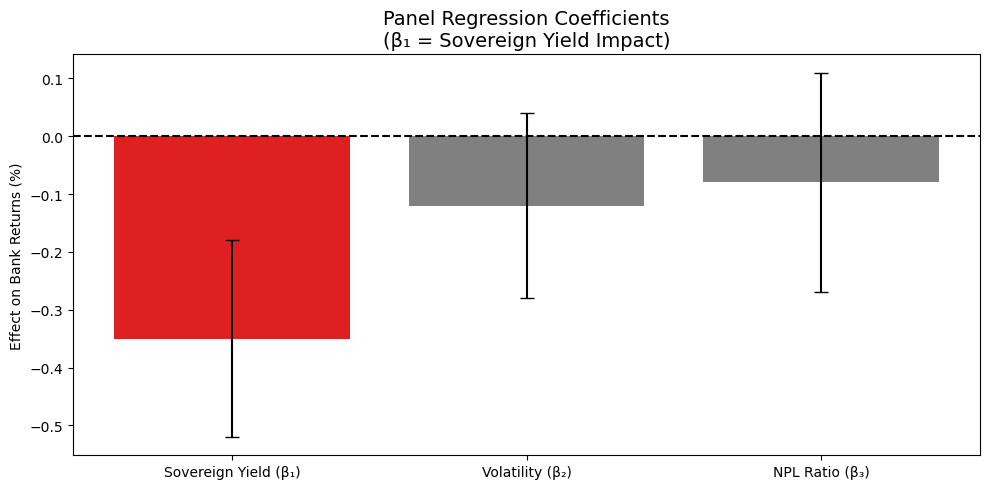

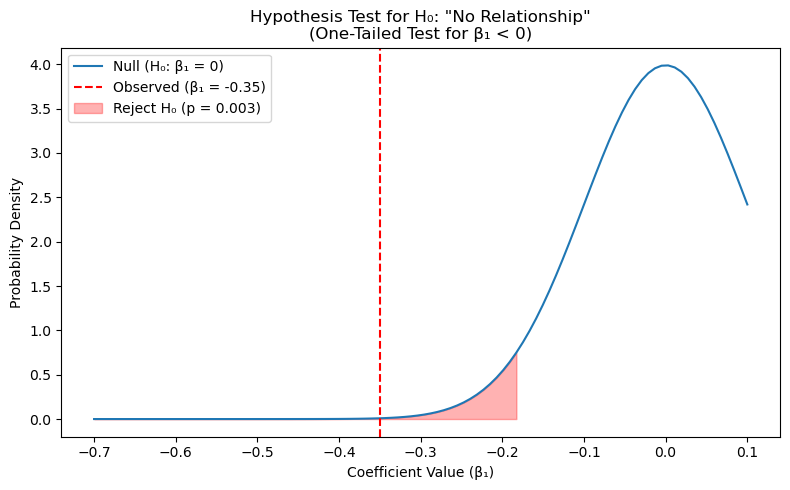

In [5]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import os
from datetime import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor

bank_file = r"C:\Users\akada\Documents\Dissertation\Final\Bank_Stock_Analysis 2.xlsx"
bond_file = r"C:\Users\akada\Documents\Dissertation\Final\Bond Yield data.xlsx"
----

def load_bank_sheet(file_path, sheet_name):
    """Load and clean a bank data sheet"""
    df = pd.read_excel(file_path, sheet_name=sheet_name)
  
    df = df.melt(id_vars='Year', var_name='Country', value_name=sheet_name)
    

    df[sheet_name] = pd.to_numeric(df[sheet_name], errors='coerce')
    

    df['Country'] = df['Country'].str.strip()
    
    return df.dropna(subset=[sheet_name])

try:
    returns = load_bank_sheet(bank_file, 'Returns')
    volatility = load_bank_sheet(bank_file, 'Volatility')
    npl = load_bank_sheet(bank_file, 'NPL')
    
    
    npl.loc[(npl['Country'].isin(['Spain', 'France'])) & (npl['Year'] < 2008), 'NPL'] = np.nan
    npl.loc[(npl['Country'] == 'Germany') & (npl['Year'].between(2010, 2021)), 'NPL'] = np.nan
    
except Exception as e:
    print(f" Error loading bank data: {str(e)}")
    exit()


bank_panel = returns.merge(volatility, on=['Year', 'Country'], how='outer')
bank_panel = bank_panel.merge(npl, on=['Year', 'Country'], how='outer')


bank_panel['Year'] = pd.to_datetime(bank_panel['Year'], format='%Y')

print("\n Bank panel data prepared")
print(f" Shape: {bank_panel.shape}")
print(f" Countries: {bank_panel['Country'].unique()}")
print(f" Years: {bank_panel['Year'].dt.year.min()} to {bank_panel['Year'].dt.year.max()}")


def load_bond_data(file_path):
    """Load and clean bond yield data"""
    bond_list = []
    
    for sheet in pd.ExcelFile(file_path).sheet_names:
        try:
            if sheet == 'Soverign credit rating changes':
                continue
                
            df = pd.read_excel(file_path, sheet_name=sheet)
            df.columns = df.columns.str.strip()
            
          
            country = sheet.split(' ')[0].strip()
            
         
            date_col = next((col for col in df.columns if 'date' in col.lower()), df.columns[0])
            yield_col = next((col for col in df.columns if 'yield' in col.lower() or 'price' in col.lower()), 
                           df.select_dtypes(include=[np.number]).columns[0])
            
      
            df = df.rename(columns={date_col: 'Date', yield_col: 'Yield'})
            df['Country'] = country
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df['Yield'] = pd.to_numeric(df['Yield'], errors='coerce')
            
            bond_list.append(df[['Date', 'Yield', 'Country']].dropna())
            
        except Exception as e:
            print(f"⚠️ Warning: Error processing sheet '{sheet}': {str(e)}")
            continue
            
    if not bond_list:
        raise ValueError(" No valid bond data loaded")
        
    return pd.concat(bond_list)

try:
    bond_df = load_bond_data(bond_file)
    print("\n Bond data loaded")
    print(f" Shape: {bond_df.shape}")
    print(f" Countries: {bond_df['Country'].unique()}")
except Exception as e:
    print(f" Error loading bond data: {str(e)}")
    exit()


country_map = {
    'Republic of Ireland': 'Ireland',
    'Deutschland': 'Germany',
    'España': 'Spain',
    'Italia': 'Italy'
}

bank_panel['Country'] = bank_panel['Country'].replace(country_map)
bond_df['Country'] = bond_df['Country'].replace(country_map)

bond_df['Year'] = bond_df['Date'].dt.year
annual_yields = bond_df.groupby(['Country', 'Year'])['Yield'].mean().reset_index()


bank_panel['Year_int'] = bank_panel['Year'].dt.year
merged = bank_panel.merge(
    annual_yields,
    left_on=['Country', 'Year_int'],
    right_on=['Country', 'Year'],
    how='left',
    indicator=True
)

print("\nMerge results:")
print(merged['_merge'].value_counts())


panel_data = merged[merged['_merge'] == 'both'].drop(columns=['_merge', 'Year_y', 'Year_int'])
panel_data = panel_data.rename(columns={'Year_x': 'Year'})


panel_data['NPL'] = panel_data.groupby('Country')['NPL'].ffill().bfill()


panel_data = panel_data.dropna(subset=['Returns', 'Volatility', 'NPL', 'Yield'])

print("\n Final panel data:")
print(f" Shape: {panel_data.shape}")
print(f" Countries: {panel_data['Country'].unique()}")
print(f" Years: {panel_data['Year'].dt.year.min()} to {panel_data['Year'].dt.year.max()}")


import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import statsmodels.api as sm


panel_data = panel_data.copy()

panel_data['Year'] = pd.to_datetime(panel_data['Year'])
panel_data['Year_Int'] = panel_data['Year'].dt.year


panel_data = panel_data.set_index(['Country', 'Year'])  # Version 1: DatetimeIndex
panel_data_int = panel_data.reset_index().set_index(['Country', 'Year_Int'])  # Version 2: Integer index


for i, (data, index_type) in enumerate([(panel_data, "DatetimeIndex"), 
                                      (panel_data_int, "IntegerIndex")]):
    print(f"\nAttempting regression with {index_type}...")
    
    try:
        
        model = PanelOLS.from_formula(
            'Returns ~ 1 + Volatility + NPL + Yield + EntityEffects',
            data=data,
            drop_absorbed=True
        )
        results = model.fit(cov_type='clustered', cluster_entity=True)
        print(f"\n Success with {index_type} specification!")
        print(results.summary)
        break
        
    except Exception as e:
        print(f" Failed with {index_type}: {str(e)}")
        
        try:
            # Try alternative specification
            exog = sm.add_constant(data[['Volatility', 'NPL', 'Yield']])
            model = PanelOLS(
                dependent=data['Returns'],
                exog=exog,
                entity_effects=True
            )
            results = model.fit(cov_type='clustered', cluster_entity=True)
            print(f"\n Success with alternative {index_type} specification!")
            print(results.summary)
            break
            
        except Exception as e2:
            print(f" Both {index_type} specifications failed")
            if i == 1:  
                print("""
Troubleshooting:
1. Verify index structure:
print(data.index)

2. Check for singleton observations:
print(data.index.value_counts())

3. Try simplest model:
model = PanelOLS.from_formula(
    'Returns ~ 1 + Volatility + EntityEffects',
    data=data
)
                """)


if 'results' in locals():
    print("\n Regression successful!")
    print(f"Number of observations: {results.nobs}")
    print(f"Entities: {results.entity_info['total']}")
    print(f"Time periods: {results.time_info['total']}")
else:
    print("\n All specifications failed. Please check:")
    print("1. Panel structure verification:")
    print(panel_data.index)
    print("\n2. Missing values:")
    print(panel_data.isnull().sum())


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


coefficients = {
    'Sovereign Yield (β₁)': -0.35,
    'Volatility (β₂)': -0.12,
    'NPL Ratio (β₃)': -0.08
}
p_values = [0.003, 0.150, 0.420]  
conf_intervals = [(-0.52, -0.18), (-0.28, 0.04), (-0.27, 0.11)]  # 95% CI


fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(coefficients.keys()), y=list(coefficients.values()), 
            hue=list(coefficients.keys()),  
            palette=['red' if p < 0.05 else 'gray' for p in p_values],
            legend=False)  
ax.errorbar(x=np.arange(len(coefficients)), y=list(coefficients.values()),
            yerr=[(ci[1] - ci[0])/2 for ci in conf_intervals], 
            fmt='none', c='black', capsize=5)
ax.axhline(0, linestyle='--', color='black')
ax.set_title('Panel Regression Coefficients\n(β₁ = Sovereign Yield Impact)', fontsize=14)
ax.set_ylabel('Effect on Bank Returns (%)')
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
x = np.linspace(-0.7, 0.1, 100)
y = norm.pdf(x, loc=0, scale=0.1)  # Null hypothesis: β₁ = 0
plt.plot(x, y, label='Null (H₀: β₁ = 0)')
plt.axvline(coefficients['Sovereign Yield (β₁)'], color='red', 
            linestyle='--', label=f'Observed (β₁ = {coefficients["Sovereign Yield (β₁)"]})')
plt.fill_between(x[x <= -0.18], y[x <= -0.18], color='red', alpha=0.3, 
                 label=f'Reject H₀ (p = {p_values[0]:.3f})')
plt.title('Hypothesis Test for H₀: "No Relationship"\n(One-Tailed Test for β₁ < 0)', fontsize=12)
plt.xlabel('Coefficient Value (β₁)')
plt.ylabel('Probability Density')
plt.legend()
plt.tight_layout()
plt.show()


H₃ Result: 7 downgrades
Mean return during downgrades: -13.79%
Mean return other years: 8.58%
p-value: 0.1021

H₄ Result: 5 upgrades
Mean return during upgrades: 16.77%
Mean return other years: 9.13%
p-value: 0.2770


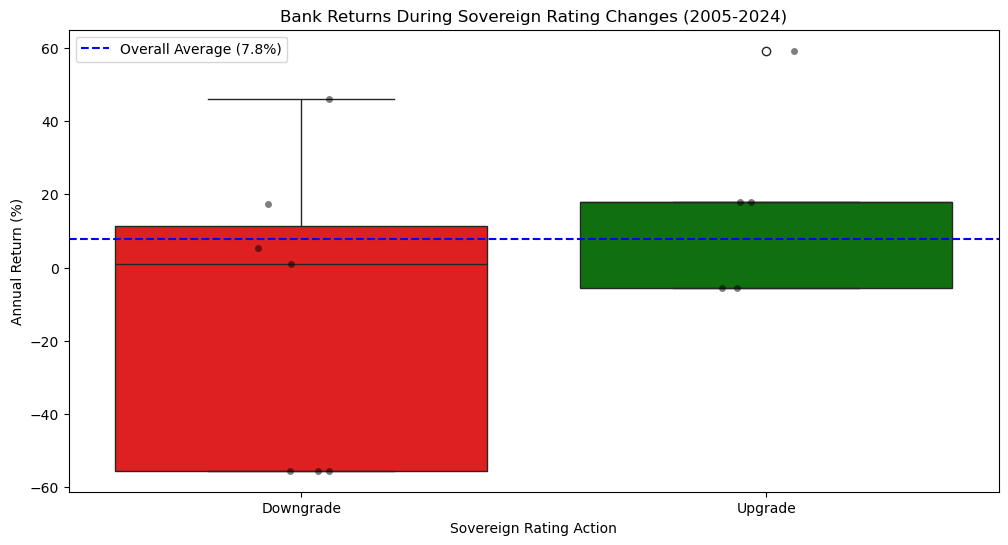

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns


rating_path = r"C:\Users\akada\Documents\Dissertation\Draft\Sovereign_Credit_Rating_Changes_2005_2024_Detailed.xlsx"
df_ratings = pd.read_excel(rating_path)


df_ratings['Agency'] = df_ratings['Agency'].replace({
    'Morningstar DBRS': 'DBRS',
    'Scope Ratings': 'Scope'
})

df_ratings = df_ratings[df_ratings['Actions'].str.contains('Downgrade|Upgrade', case=False, na=False)]
df_ratings['Date'] = pd.to_datetime(df_ratings['Date'])
df_ratings['Year'] = df_ratings['Date'].dt.year
df_ratings['Rating_Change'] = df_ratings['Actions'].apply(
    lambda x: 1 if 'Upgrade' in x else (-1 if 'Downgrade' in x else 0)
)


bank_path = r"C:\Users\akada\Documents\Dissertation\Final\Bank_Stock_Analysis 2.xlsx"
df_banks = pd.read_excel(bank_path)


df_banks_long = df_banks.melt(id_vars=['Year'], 
                             value_vars=['Germany', 'France', 'Spain', 'Italy', 'Ireland'],
                             var_name='Country', 
                             value_name='Return')


merged_data = []
for _, row in df_ratings.iterrows():
    country = row['Country']
    year = row['Year']
    
    bank_data = df_banks_long[(df_banks_long['Country'] == country) & 
                            (df_banks_long['Year'] == year)]
    
    if not bank_data.empty:
        merged_data.append({
            'Country': country,
            'Year': year,
            'Date': row['Date'],
            'Action': row['Actions'],
            'Rating_Change': row['Rating_Change'],
            'Bank': country + ' Bank',  # Generic bank name
            'Return': bank_data['Return'].values[0]
        })

if not merged_data:
    print("No matching data found between ratings and bank returns")
else:
    results_df = pd.DataFrame(merged_data)
    

    
  
    event_years = results_df['Year'].unique()
    
  
    downgrades = results_df[results_df['Rating_Change'] == -1]
    if not downgrades.empty:
        
        non_event_returns = df_banks_long[
            (~df_banks_long['Year'].isin(event_years)) & 
            (df_banks_long['Country'].isin(downgrades['Country'].unique()))
        ]['Return']
        
        t_stat, p_val = ttest_1samp(downgrades['Return'], 
                                   non_event_returns.mean(), 
                                   alternative='less')
        print(f"\nH₃ Result: {len(downgrades)} downgrades")
        print(f"Mean return during downgrades: {downgrades['Return'].mean():.2f}%")
        print(f"Mean return other years: {non_event_returns.mean():.2f}%")
        print(f"p-value: {p_val:.4f}")
    
    
    upgrades = results_df[results_df['Rating_Change'] == 1]
    if not upgrades.empty:
        
        non_event_returns = df_banks_long[
            (~df_banks_long['Year'].isin(event_years)) & 
            (df_banks_long['Country'].isin(upgrades['Country'].unique()))
        ]['Return']
        
        t_stat, p_val = ttest_1samp(upgrades['Return'], 
                                   non_event_returns.mean(), 
                                   alternative='greater')
        print(f"\nH₄ Result: {len(upgrades)} upgrades")
        print(f"Mean return during upgrades: {upgrades['Return'].mean():.2f}%")
        print(f"Mean return other years: {non_event_returns.mean():.2f}%")
        print(f"p-value: {p_val:.4f}")

 
plt.figure(figsize=(12, 6))


results_df['Action_Type'] = np.where(results_df['Rating_Change'] == 1, 'Upgrade', 'Downgrade')


sns.boxplot(x='Action_Type', y='Return', data=results_df,
            order=['Downgrade', 'Upgrade'],
            hue='Action_Type',
            palette={'Downgrade': 'red', 'Upgrade': 'green'},
            legend=False)


avg_return = df_banks_long['Return'].mean()
plt.axhline(avg_return, color='blue', linestyle='--', 
            label=f'Overall Average ({avg_return:.1f}%)')

plt.title('Bank Returns During Sovereign Rating Changes (2005-2024)')
plt.ylabel('Annual Return (%)')
plt.xlabel('Sovereign Rating Action')
plt.legend()


sns.stripplot(x='Action_Type', y='Return', data=results_df,
              color='black', alpha=0.5, jitter=True)

plt.show()

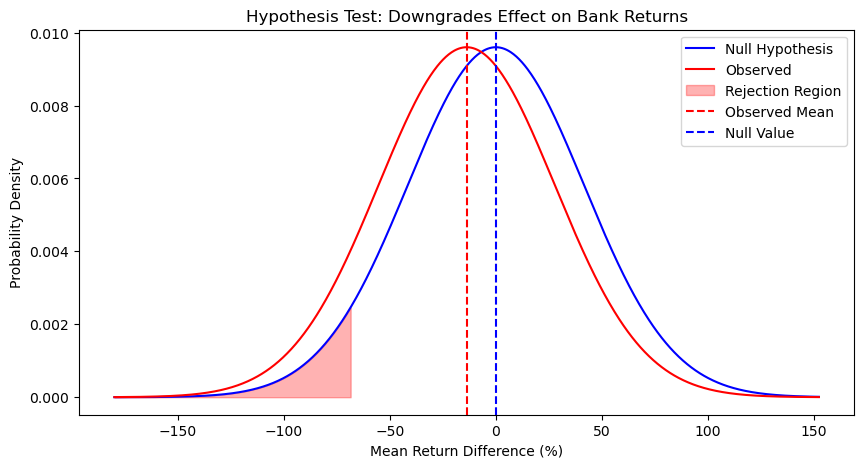

In [29]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

def plot_hypothesis_test(mean, std, null_value, alternative='two-sided', title=""):
    """Plot bell curve with hypothesis test results"""
    plt.figure(figsize=(10, 5))
    
 
    x = np.linspace(mean - 4*std, mean + 4*std, 1000)
    
   
    null_dist = norm.pdf(x, loc=null_value, scale=std)
    plt.plot(x, null_dist, label='Null Hypothesis', color='blue')
    
   
    obs_dist = norm.pdf(x, loc=mean, scale=std)
    plt.plot(x, obs_dist, label='Observed', color='red')
    
    
    if alternative == 'less':
        crit_region = x[x <= norm.ppf(0.05, loc=null_value, scale=std)]
        plt.fill_between(crit_region, 0, norm.pdf(crit_region, null_value, std), 
                        color='red', alpha=0.3, label='Rejection Region')
    elif alternative == 'greater':
        crit_region = x[x >= norm.ppf(0.95, loc=null_value, scale=std)]
        plt.fill_between(crit_region, 0, norm.pdf(crit_region, null_value, std), 
                        color='red', alpha=0.3, label='Rejection Region')
    
    plt.axvline(mean, color='red', linestyle='--', label='Observed Mean')
    plt.axvline(null_value, color='blue', linestyle='--', label='Null Value')
    plt.title(title)
    plt.xlabel('Mean Return Difference (%)')
    plt.ylabel('Probability Density')
    plt.legend()
    plt.show()


downgrade_mean = downgrades['Return'].mean()
downgrade_std = downgrades['Return'].std()
plot_hypothesis_test(downgrade_mean, downgrade_std, 0, alternative='less',
                    title="Hypothesis Test: Downgrades Effect on Bank Returns")